In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### The Data

$$
f(x) = \sin(2 \pi x) + \epsilon
$$


In [2]:
# Training data
train_x = torch.linspace(0, 1, 100) # 100 points in [0,1] 
# use f(x) = sin(2*pi*x) + Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi))  + torch.randn(train_x.size()) * math.sqrt(0.04)

# **1. GP regression**

### The Model

In [3]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean() #  prior mean of the GP
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()) # prior covariance of the GP

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Train Model

In [4]:
training_iter = 150

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/150 - Loss: 0.931   lengthscale: 0.693   noise: 0.693
Iter 2/150 - Loss: 0.899   lengthscale: 0.644   noise: 0.644
Iter 3/150 - Loss: 0.864   lengthscale: 0.598   noise: 0.598
Iter 4/150 - Loss: 0.825   lengthscale: 0.555   noise: 0.554
Iter 5/150 - Loss: 0.782   lengthscale: 0.514   noise: 0.513
Iter 6/150 - Loss: 0.734   lengthscale: 0.475   noise: 0.474
Iter 7/150 - Loss: 0.682   lengthscale: 0.438   noise: 0.437
Iter 8/150 - Loss: 0.630   lengthscale: 0.404   noise: 0.402
Iter 9/150 - Loss: 0.581   lengthscale: 0.371   noise: 0.369
Iter 10/150 - Loss: 0.536   lengthscale: 0.342   noise: 0.339
Iter 11/150 - Loss: 0.495   lengthscale: 0.315   noise: 0.310
Iter 12/150 - Loss: 0.457   lengthscale: 0.292   noise: 0.284
Iter 13/150 - Loss: 0.420   lengthscale: 0.273   noise: 0.259
Iter 14/150 - Loss: 0.384   lengthscale: 0.257   noise: 0.237
Iter 15/150 - Loss: 0.348   lengthscale: 0.244   noise: 0.216
Iter 16/150 - Loss: 0.313   lengthscale: 0.234   noise: 0.196
Iter 17/150 - Los

### Test model

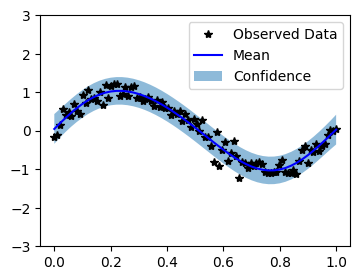

In [5]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

### Get model info

In [6]:
# Viewing model hyperparameters
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = -3.48028302192688
Parameter name: mean_module.raw_constant                   value = -0.040148086845874786
Parameter name: covar_module.raw_outputscale               value = 0.8395853638648987
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -1.2064292430877686


In [7]:
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-3.4803])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.raw_constant', tensor(-0.0401)),
             ('covar_module.raw_outputscale', tensor(0.8396)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-1.2064]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf))])

### Save model

In [8]:
save_model = False
if save_model:
    torch.save(model.state_dict(), 'model_state.pth')

# **2. GP + ANN regression**

### The Model

In [9]:
class GPWithNNFeatureExtractor(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPWithNNFeatureExtractor, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Linear(1, 2),
            torch.nn.ReLU(),
            torch.nn.Linear(2, 2),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Train Model

In [10]:
# number of iterations
training_iter = 1500

# initialize likelihood and model
ann_likelihood = gpytorch.likelihoods.GaussianLikelihood()
ann_model = GPWithNNFeatureExtractor(train_x, train_y, ann_likelihood)

# Find optimal model hyperparameters
ann_model.train()
ann_likelihood.train()

# Use the adam optimizer
ann_optimizer = torch.optim.Adam(ann_model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(ann_likelihood, ann_model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    ann_optimizer.zero_grad()
    # Output from model
    output = ann_model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        ann_model.covar_module.base_kernel.lengthscale.item(),
        ann_model.likelihood.noise.item()
    ))
    ann_optimizer.step()

Iter 1/1500 - Loss: 0.958   lengthscale: 0.693   noise: 0.693
Iter 2/1500 - Loss: 0.953   lengthscale: 0.688   noise: 0.688
Iter 3/1500 - Loss: 0.948   lengthscale: 0.683   noise: 0.683
Iter 4/1500 - Loss: 0.944   lengthscale: 0.678   noise: 0.678
Iter 5/1500 - Loss: 0.939   lengthscale: 0.673   noise: 0.673
Iter 6/1500 - Loss: 0.934   lengthscale: 0.668   noise: 0.669
Iter 7/1500 - Loss: 0.929   lengthscale: 0.664   noise: 0.664
Iter 8/1500 - Loss: 0.924   lengthscale: 0.659   noise: 0.659
Iter 9/1500 - Loss: 0.919   lengthscale: 0.654   noise: 0.654
Iter 10/1500 - Loss: 0.914   lengthscale: 0.649   noise: 0.649
Iter 11/1500 - Loss: 0.909   lengthscale: 0.644   noise: 0.644
Iter 12/1500 - Loss: 0.903   lengthscale: 0.639   noise: 0.640
Iter 13/1500 - Loss: 0.898   lengthscale: 0.635   noise: 0.635
Iter 14/1500 - Loss: 0.892   lengthscale: 0.630   noise: 0.630
Iter 15/1500 - Loss: 0.886   lengthscale: 0.625   noise: 0.625
Iter 16/1500 - Loss: 0.879   lengthscale: 0.620   noise: 0.621
I

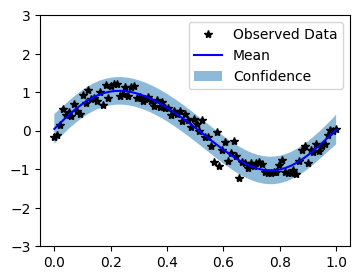

In [11]:
# Get into evaluation (predictive posterior) mode
ann_model.eval()
ann_likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = ann_likelihood(ann_model(test_x))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

### Get model info

In [12]:
ann_model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-3.4817])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.raw_constant', tensor(-0.0402)),
             ('covar_module.raw_outputscale', tensor(0.8391)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-0.4213]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf)),
             ('feature_extractor.0.weight',
              tensor([[1.0073],
                      [0.8704]])

References
- https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html